In [ ]:
%%capture --no-stderr
%pip install langchain_community tiktoken langchainhub chromadb langchain langgraph tavily-python langchain-text-splitters arxiv langchain_openai pymupdf faiss-cpu

In [2]:
import getpass
import os

os.environ["OPENAI_API_KEY"] = getpass.getpass()

In [3]:
os.environ["TAVILY_API_KEY"] = getpass.getpass()

In [4]:
from tavily import TavilyClient
tavily = TavilyClient(api_key=os.environ["TAVILY_API_KEY"])

In [5]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini", temperature = 0)

In [6]:
## create vector store
from langchain_community.document_loaders import WebBaseLoader
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import Chroma
from langchain_text_splitters import RecursiveCharacterTextSplitter

urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs_list)

# Add to vectorDB
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding = OpenAIEmbeddings(model="text-embedding-3-small")
)
retriever = vectorstore.as_retriever()

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [271]:
# graph state
from typing_extensions import TypedDict
from typing import List

class GraphState(TypedDict):
    question: str
    documents: List[str]
    web_search: str
    score: str
    generation: str

In [272]:
# retrieval documents
from langchain_core.prompts import ChatPromptTemplate

def retrieve_documents(state: GraphState) -> GraphState:
    """
    Retrieve documents relevant to a user question
    
    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Retrieved documents and updated web_search state
    """
    
    documents = retriever.invoke(state["question"])
    
    return GraphState(
        question=state["question"],
        documents=documents,
        generation=state["generation"],
        web_search="no",
        score="",
    )

In [273]:
# relevance checker
from langchain_core.output_parsers import JsonOutputParser

def check_relevance(state: GraphState) -> str:
    """
    Check relevance of a document to a user question
    
    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Filtered out irrelevant documents and updated web_search state
    """
    system = """You are a grader assessing relevance
        of a retrieved document to a user question. If the document contains keywords related to the user question,
        grade it as relevant. It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question. \n
        Provide the binary score as a JSON with a single key 'score' and no premable or explanation.
        """
    
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", "question: {question}\n\n document: {document} "),
        ]
    )
    
    checker = prompt | llm | JsonOutputParser()
    
    response = checker.invoke({"question": state["question"], "document": state["documents"]})
    return response["score"]

In [274]:
# generate answer
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

def generate_answer(state: GraphState) -> GraphState:
    """
    Generate an answer to a user question
    
    Args:
        state (dict): The current graph state

    Returns:
        str: The answer to the user question
    """
    system = """You are an assistant for question-answering tasks.
    Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know.
    Use three sentences maximum and keep the answer concise"""

    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", "question: {question}\n\n context: {context} "),
        ]
    )
    
    # Chain
    chain = prompt | llm | StrOutputParser()
    
    response = chain.invoke({"question": state["question"], "context": state["documents"]})
    return GraphState(
        question=state["question"],
        documents=state["documents"],
        web_search=state["web_search"],
        generation=response,
        score="",
    )

In [296]:
from langchain_core.documents import Document

def web_search_tavily(state: GraphState) -> GraphState:
    """
    Web search based based on the question

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Appended web results to documents
    """

    print("---WEB SEARCH---")
    question = state["question"]
    documents = state["documents"]

    # Web search
    response = tavily.search(query=question, max_results=5)
    docs = response['results']
    print("Web search results:\n")
    #print(docs)
    web_results = []
    for doc in docs:
        web_results.append(Document(
            page_content=doc["content"],
            metadata={"title": doc["title"], "source": doc["url"]}
        ))
    #web_results = "\n".join([d["content"] for d in docs])
    #web_results = Document(page_content=web_results)
    
    return GraphState(
        question=state["question"],
        documents=web_results,
        web_search="yes",
        generation=state["generation"],
        score="",
    )

In [297]:
# hallucination checker
from langchain_core.prompts import ChatPromptTemplate

def check_hallucination(state: GraphState) -> str:
    h_system = """You are a grader assessing whether
    an answer is grounded in / supported by a set of facts. Give a binary 'yes' or 'no' score to indicate
    whether the answer is grounded in / supported by a set of facts. Provide the binary score as a JSON with a
    single key 'score' and no preamble or explanation."""

    h_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", h_system),
            ("human", "documents: {documents}\n\n answer: {generation} "),
        ]
    )
    
    h_chain = h_prompt | llm | JsonOutputParser()
    
    a_system = """You are a grader assessing whether an
    answer is useful to resolve a question. Give a binary score 'yes' or 'no' to indicate whether the answer is
    useful to resolve a question. Provide the binary score as a JSON with a single key 'score' and no preamble or explanation."""

    a_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", a_system),
            ("human", "question: {question}\n\n answer: {generation} "),
        ]
    )
    
    answer_grader = a_prompt | llm | JsonOutputParser()
    
    score = h_chain.invoke({"documents": state["documents"], "generation": state["generation"]})
    grade = score["score"]
    
    if grade == "yes":
        answer = answer_grader.invoke({"question": state["question"], "generation": state["generation"]})
        grade = answer["score"]
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
    else:
        pprint("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"

In [298]:
# generation final output

def generate_final_output(state:GraphState) -> GraphState:
    """
    Generate final output
    
    Args:
        state (dict): The current graph state

    Returns:
        state (dict): The final output
    """
    return GraphState(
        question=state["question"],
        documents=state["documents"],
        web_search=state["web_search"],
        generation=state["generation"],
        score="final",
    )

In [299]:
# graph transitions
from langgraph.graph import END, StateGraph

workflow = StateGraph(GraphState)

workflow.add_node("retrieve", retrieve_documents)  # retrieve documents
workflow.add_node("generate", generate_answer)  # generate answer
workflow.add_node("web_search_tavily", web_search_tavily)  # generate answer
workflow.add_node("final_output", generate_final_output)  # generate final output

workflow.set_entry_point("retrieve")
workflow.add_conditional_edges(
    "retrieve",
    check_relevance,
    {"yes": "generate", "no": "web_search_tavily"},
)
workflow.add_conditional_edges("web_search_tavily", 
    check_relevance,
    {"yes": "generate", "no": "web_search_tavily"},)
workflow.add_conditional_edges(
    "generate",
    check_hallucination,
    {
        "not supported": "generate",
        "useful": "final_output",
        "not useful": "web_search_tavily",
    },
)


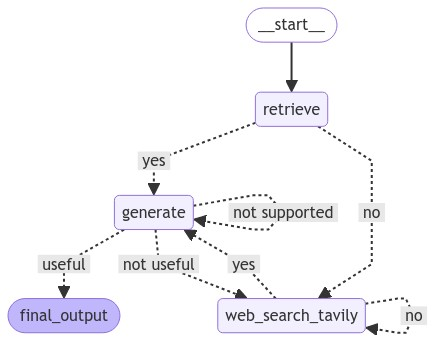

In [300]:
from IPython.display import Image, display
app = workflow.compile()
display(Image(app.get_graph().draw_mermaid_png()))

In [301]:
def get_document_references(state:GraphState):
    documents = state["documents"]
    result = []
    for doc in documents:
        try:
            title = doc.metadata["title"]
            source = doc.metadata["source"]
            result.append(f"{title} ({source})")
        except:
            pass
    return "\n".join(result)

In [302]:
from pprint import pprint

#inputs = {"question": "What is prompt?"}
inputs = {"question": "Who won the gold medal in archery at the Paris Olympics?"}

output = ""
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
        if key == "final_output":
            rag_type = "Vector Store"
            if value["web_search"] == "yes":
                rag_type = "Web Search"
            print(f"Answer: {value['generation']}\n")
            print(f"Rag Type: {rag_type}\n")
            print(f"References\n{get_document_references(value)}")
            break
        

'Finished running: retrieve:'
---WEB SEARCH---
Web search results:

'Finished running: web_search_tavily:'
---DECISION: GENERATION ADDRESSES QUESTION---
'Finished running: generate:'
'Finished running: final_output:'
Answer: South Korea won the gold medal in both the men's and women's team archery events at the Paris Olympics. They defeated France 5-1 in the men's final and edged out China 5-4 in the women's final. This victory marked South Korea's continued dominance in archery.

Rag Type: Web Search

References
South Korea beats France to win gold in men's archery team event (https://www.espn.com/olympics/story/_/id/40673341/south-korea-beats-france-win-gold-men-archery-team-event)
South Korea edges China for archery Olympic gold after check with a ... (https://apnews.com/article/olympics-2024-archery-south-korea-0f387d5b04061b26d3522037e9030f38)
South Korea archery win decided in nail-biting shootout - NBC New York (https://www.nbcnewyork.com/paris-2024-summer-olympics/south-korea-a